In [1]:
# Numpy
import numpy as np
import scipy as sc

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse
from utils.sqrtm import sqrtm
from utils.utils import AverageMeter, DCN

In [2]:
def data_loader(file_num, batch_size):
    # (# of trajectories, length of trajectory, # of dimension)
    with open(f'./data/train/trj_{file_num}.npy', 'rb') as f:
        train_data = np.load(f)
    with open(f'./data/test/trj_{file_num}.npy', 'rb') as f:
        test_data = np.load(f)
        
    train_data = TensorDataset(torch.FloatTensor(train_data[:, :-1].reshape(-1, 2)), 
                               torch.FloatTensor(np.diff(train_data, axis=-2).reshape(-1, 2)))
    test_data = TensorDataset(torch.FloatTensor(test_data[:, :-1].reshape(-1, 2)), 
                              torch.FloatTensor(np.diff(test_data, axis=-2).reshape(-1, 2)))

    train_loader = DataLoader(
                train_data,
                batch_size=batch_size,
                shuffle=True,
                pin_memory=True,

            )
    test_loader = DataLoader(
                test_data,
                batch_size=batch_size * 10,
                shuffle=False,
                pin_memory=True,
            )
        
    return train_loader, test_loader

<IPython.core.display.Javascript object>


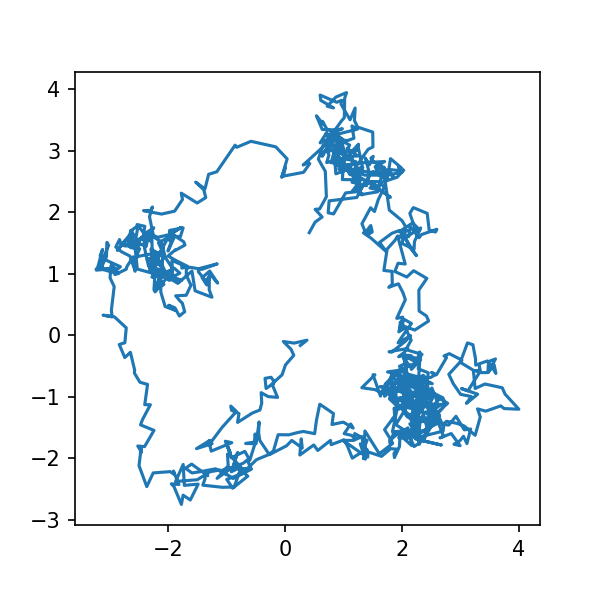

In [90]:
file_num = str(3)
# (# of trajectories, length of trajectory, # of dimension)
with open('./data/train/trj_'+ file_num + '.npy', 'rb') as f:
    train_data = np.load(f)
with open('./data/test/trj_'+ file_num + '.npy', 'rb') as f:
    test_data = np.load(f)
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
n = 4
t = 1000
ax.plot(train_data[n][:t, 0], train_data[n][:t, 1])

In [3]:
# Set random seed for reproducibility
SEED = 2589
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


class FieldLearning(nn.Module):
    def __init__(self, input_dim, output_dim, d, dt):
        super(FieldLearning, self).__init__()
        self.d = d  # space dimension
        self.dt = torch.tensor(dt)
        
        self.force_model = nn.Sequential(
            nn.Linear(input_dim, 256),            # [batch, 12, 16, 16]
            nn.ELU(),
            nn.Linear(256, 256),           # [batch, 24, 8, 8]
            nn.ELU(),
            nn.Linear(256, 256),           # [batch, 24, 8, 8]
            nn.ELU(),
            nn.Linear(256, output_dim),           # [batch, 48, 4, 4]
        )
        
        #x = np.ones((d, d))
        #y = sc.linalg.sqrtm(x)
        #self.diff_model = torch.nn.Parameter(torch.tensor(y))
        self.diag_ind = torch.stack([torch.arange(self.d), torch.arange(self.d)])
        self.off_diag_ind = torch.tril_indices(self.d, self.d, -1)
        self.diag_param = torch.nn.Parameter(torch.zeros(self.d))
        self.off_diag_param = torch.nn.Parameter(torch.zeros(int(self.d * (self.d - 1) / 2)))
        
        print(f"# of diag_param : {len(self.diag_param)}, # of off_diag_param : {len(self.off_diag_param)}")
        

    def forward(self, x):
        loc = self.force_model(x)
        scale_tril = torch.zeros(self.d, self.d).cuda()
        scale_tril[self.diag_ind[0], self.diag_ind[1]] = 1 + F.elu(self.diag_param)
        scale_tril[self.off_diag_ind[0], self.off_diag_ind[1]] = self.off_diag_param
        return loc * self.dt, scale_tril * torch.sqrt(self.dt)

In [70]:
# File setting
file_num = 3
data_dim = 2

# Create model
model = FieldLearning(input_dim=data_dim, output_dim=data_dim, d=data_dim, dt=0.001).cuda()
train_loader, test_loader = data_loader(file_num, batch_size=128)

# Define settings
epochs = 10000
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# of diag_param : 2, # of off_diag_param : 1


In [5]:
best_test_loss = np.inf

for epoch in range(epochs):
    train_losses = AverageMeter("TrainLoss")
    test_losses = AverageMeter("TestLoss")
    for data, labels in train_loader:
        loc, scale_tril = model(data.cuda())
        dist = torch.distributions.MultivariateNormal(loc=loc, scale_tril=scale_tril)
        train_loss = - dist.log_prob(labels.cuda()).mean()
        train_loss.backward()
        optimizer.step()
        train_losses.update(train_loss.item(), data.shape[0])
        
    print(f'[Epoch {epoch}] Train loss :{train_losses.avg}')
    
    with torch.no_grad():
        for data, labels in test_loader:
            loc, scale_tril = model(data.cuda())
            dist = torch.distributions.MultivariateNormal(loc=loc, scale_tril=scale_tril)
            test_loss = - dist.log_prob(labels.cuda()).mean()
            test_losses.update(test_loss.item(), data.shape[0])

        print(f'[Epoch {epoch}] Test loss :{test_losses.avg}')
        is_best = test_losses.avg < best_test_loss
        
        if is_best or epoch == epochs - 1:
            best_test_loss = test_losses.avg
            print(f"save at epoch {epoch} : loss : {test_losses.avg}")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": test_loss,
                },
                f"./result/model/checkpoint_file{file_num}_{epoch}.pth",
            )

[Epoch 0] Train loss :13.484360747323512
[Epoch 0] Test loss :11.713050159271603
save at epoch 0 : loss : 11.713050159271603
[Epoch 1] Train loss :10.591789981835555
[Epoch 1] Test loss :9.574941762173959
save at epoch 1 : loss : 9.574941762173959
[Epoch 2] Train loss :8.695516239658023
[Epoch 2] Test loss :7.889117455999903
save at epoch 2 : loss : 7.889117455999903
[Epoch 3] Train loss :7.219134387720083
[Epoch 3] Test loss :6.5729804499004585
save at epoch 3 : loss : 6.5729804499004585
[Epoch 4] Train loss :6.013209031527848
[Epoch 4] Test loss :5.485817384572014
save at epoch 4 : loss : 5.485817384572014
[Epoch 5] Train loss :5.018699725666384
[Epoch 5] Test loss :4.58527986245318
save at epoch 5 : loss : 4.58527986245318
[Epoch 6] Train loss :4.193721048280899
[Epoch 6] Test loss :3.8250087533405823
save at epoch 6 : loss : 3.8250087533405823
[Epoch 7] Train loss :3.4995179534280334
[Epoch 7] Test loss :3.188715944438949
save at epoch 7 : loss : 3.188715944438949
[Epoch 8] Train l

[Epoch 74] Train loss :-0.7921676959735368
[Epoch 74] Test loss :-0.7852702533177035
[Epoch 75] Train loss :-0.7788945778086968
[Epoch 75] Test loss :-0.7722203532699728
[Epoch 76] Train loss :-0.7657179175649765
[Epoch 76] Test loss :-0.7592485189771686
[Epoch 77] Train loss :-0.7521925350787318
[Epoch 77] Test loss :-0.7457499476990374
[Epoch 78] Train loss :-0.739149595854914
[Epoch 78] Test loss :-0.7320853498962262
[Epoch 79] Train loss :-0.72572886414928
[Epoch 79] Test loss :-0.7189335333822918
[Epoch 80] Train loss :-0.7122865474709321
[Epoch 80] Test loss :-0.7054467802179349
[Epoch 81] Train loss :-0.6989734460916719
[Epoch 81] Test loss :-0.6913952780790431
[Epoch 82] Train loss :-0.6856494370028071
[Epoch 82] Test loss :-0.6787560313030987
[Epoch 83] Train loss :-0.6722733395690261
[Epoch 83] Test loss :-0.6650236557931801
[Epoch 84] Train loss :-0.6587864439231609
[Epoch 84] Test loss :-0.6515396769028423
[Epoch 85] Train loss :-0.6452441492585232
[Epoch 85] Test loss :-0.

[Epoch 168] Test loss :0.3149954020929332
[Epoch 169] Train loss :0.31980913960250545
[Epoch 169] Test loss :0.3247304608683811
[Epoch 170] Train loss :0.3291790738798688
[Epoch 170] Test loss :0.33385516268716525
[Epoch 171] Train loss :0.3386344734448554
[Epoch 171] Test loss :0.34312246159108023
[Epoch 172] Train loss :0.34790720047301227
[Epoch 172] Test loss :0.35273349842484897
[Epoch 173] Train loss :0.35722177955422096
[Epoch 173] Test loss :0.3616764909029603
[Epoch 174] Train loss :0.3666570068699251
[Epoch 174] Test loss :0.37150676571282043
[Epoch 175] Train loss :0.3760100743698828
[Epoch 175] Test loss :0.38074556417626876
[Epoch 176] Train loss :0.38522491744034576
[Epoch 176] Test loss :0.3899086582570067
[Epoch 177] Train loss :0.3945932169829217
[Epoch 177] Test loss :0.39936878695549016
[Epoch 178] Train loss :0.4039126913313127
[Epoch 178] Test loss :0.40858373413837984
[Epoch 179] Train loss :0.41294107479791137
[Epoch 179] Test loss :0.4171813769386534
[Epoch 180]

[Epoch 265] Train loss :1.0845164380081656
[Epoch 265] Test loss :1.087863164403961
[Epoch 266] Train loss :1.0912081331920118
[Epoch 266] Test loss :1.0945451126061436
[Epoch 267] Train loss :1.0982482382807448
[Epoch 267] Test loss :1.1057787674428796
[Epoch 268] Train loss :1.1045306258783876
[Epoch 268] Test loss :1.1078476763925669
[Epoch 269] Train loss :1.1111611298053596
[Epoch 269] Test loss :1.114468368907871
[Epoch 270] Train loss :1.1177711836105944
[Epoch 270] Test loss :1.1210687220007172
[Epoch 271] Train loss :1.1243611404444889
[Epoch 271] Test loss :1.1276490665290437
[Epoch 272] Train loss :1.1309311403910127
[Epoch 272] Test loss :1.1342095046868883
[Epoch 273] Train loss :1.137481667053367
[Epoch 273] Test loss :1.1407500369535206
[Epoch 274] Train loss :1.1440117691159069
[Epoch 274] Test loss :1.1472706268854005
[Epoch 275] Train loss :1.150522183387181
[Epoch 275] Test loss :1.1537715097655892
[Epoch 276] Train loss :1.1570131176840677
[Epoch 276] Test loss :1.1

[Epoch 362] Train loss :1.6505547364567121
[Epoch 362] Test loss :1.6531036396696157
[Epoch 363] Train loss :1.6556582517082161
[Epoch 363] Test loss :1.6582006600489914
[Epoch 364] Train loss :2.5866922492801647
[Epoch 364] Test loss :1.663284554578314
[Epoch 365] Train loss :1.6658222706182704
[Epoch 365] Test loss :1.6683480957124528
[Epoch 366] Train loss :1.6708797388871273
[Epoch 366] Test loss :1.673399735629672
[Epoch 367] Train loss :1.6759252349089737
[Epoch 367] Test loss :1.6784392177730767
[Epoch 368] Train loss :1.68095847158721
[Epoch 368] Test loss :1.6834666820845254
[Epoch 369] Train loss :1.6859797367237486
[Epoch 369] Test loss :1.6884820558462326
[Epoch 370] Train loss :1.6909889407715377
[Epoch 370] Test loss :1.6934855644792803
[Epoch 371] Train loss :1.6959862573405053
[Epoch 371] Test loss :1.6984770622738887
[Epoch 372] Train loss :1.7009716649617728
[Epoch 372] Test loss :1.7034567807552659
[Epoch 373] Train loss :1.7059453688059847
[Epoch 373] Test loss :1.7

[Epoch 459] Test loss :2.1257871268379507
[Epoch 460] Train loss :2.128211236008168
[Epoch 460] Test loss :2.1306415173349076
[Epoch 461] Train loss :2.133059987497277
[Epoch 461] Test loss :2.1354845745824123
[Epoch 462] Train loss :2.1378971992734552
[Epoch 462] Test loss :2.1403159080642333
[Epoch 463] Train loss :2.142722833653261
[Epoch 463] Test loss :2.145135959876467
[Epoch 464] Train loss :2.147537079283757
[Epoch 464] Test loss :2.1499445822468064
[Epoch 465] Train loss :2.152340019599761
[Epoch 465] Test loss :2.154741877672112
[Epoch 466] Train loss :2.1571316519393027
[Epoch 466] Test loss :2.1595279468180046
[Epoch 467] Train loss :2.1619121611563012
[Epoch 467] Test loss :2.164302906788329
[Epoch 468] Train loss :2.166681549346188
[Epoch 468] Test loss :2.169066907134172
[Epoch 469] Train loss :2.171439861449638
[Epoch 469] Test loss :2.1738195234184827
[Epoch 470] Train loss :2.1761870296936845
[Epoch 470] Test loss :2.178561310706609
[Epoch 471] Train loss :2.180923278

[Epoch 557] Test loss :2.5533764172487348
[Epoch 558] Train loss :2.5553362210448567
[Epoch 558] Test loss :2.5573012475026036
[Epoch 559] Train loss :2.5592572341645785
[Epoch 559] Test loss :2.561218404254862
[Epoch 560] Train loss :2.5631708131083037
[Epoch 560] Test loss :2.565128275737463
[Epoch 561] Train loss :2.567076921696686
[Epoch 561] Test loss :2.5690305534297555
[Epoch 562] Train loss :2.5709757151252233
[Epoch 562] Test loss :2.5729256368563265
[Epoch 563] Train loss :2.5748669965396656
[Epoch 563] Test loss :2.576813216991026
[Epoch 564] Train loss :2.5787509595686133
[Epoch 564] Test loss :2.580693342876692
[Epoch 565] Train loss :2.582627493677789
[Epoch 565] Test loss :2.584566243818634
[Epoch 566] Train loss :2.5864965988938984
[Epoch 566] Test loss :2.588431507735887


KeyboardInterrupt: 

In [71]:
model = FieldLearning(input_dim=data_dim, output_dim=data_dim, d=data_dim, dt=0.001).cuda()
file_num = 3
epoch = 43
checkpoint = torch.load(f"./result/model/checkpoint_file{file_num}_{epoch}.pth",)
model.load_state_dict(checkpoint['model_state_dict'])

# of diag_param : 2, # of off_diag_param : 1


<All keys matched successfully>

In [52]:
xs = torch.linspace(-3, 3, steps=100)
ys = torch.linspace(-3, 3, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='xy')
z = model.force_model(torch.cat((x.unsqueeze(-1).cuda(), y.unsqueeze(-1).cuda()), dim=-1))

In [79]:
%matplotlib notebook

<IPython.core.display.Javascript object>


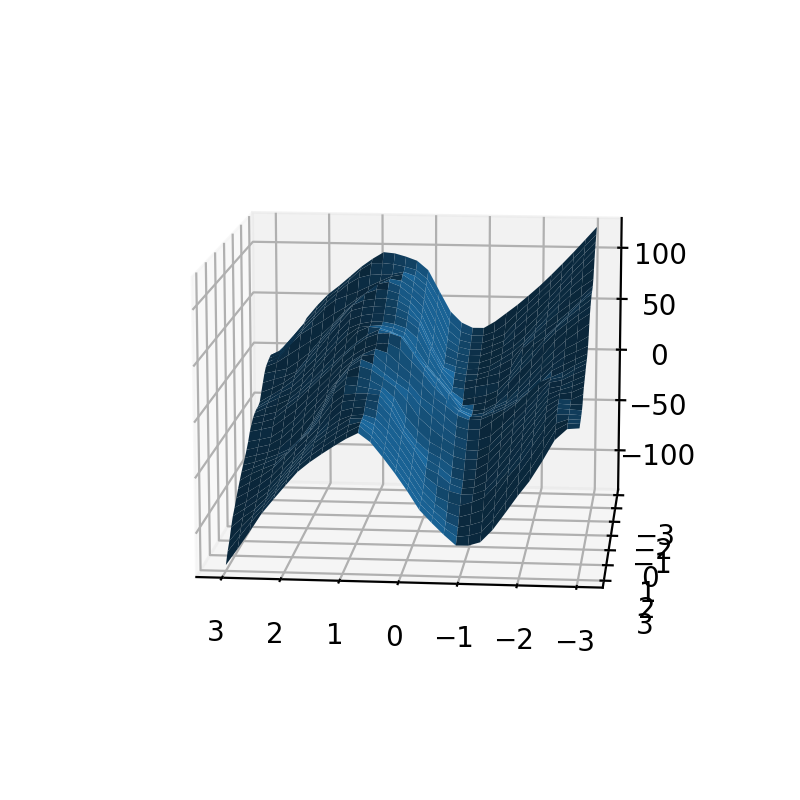

In [80]:
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), DCN(z[..., 0]))

<IPython.core.display.Javascript object>


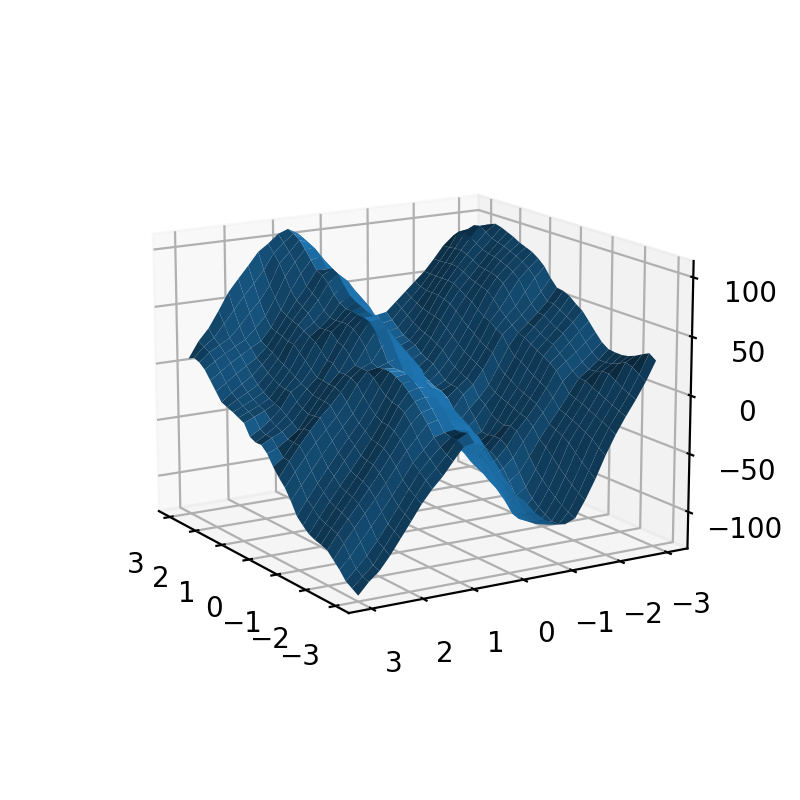

In [81]:
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), DCN(z[..., 1]))

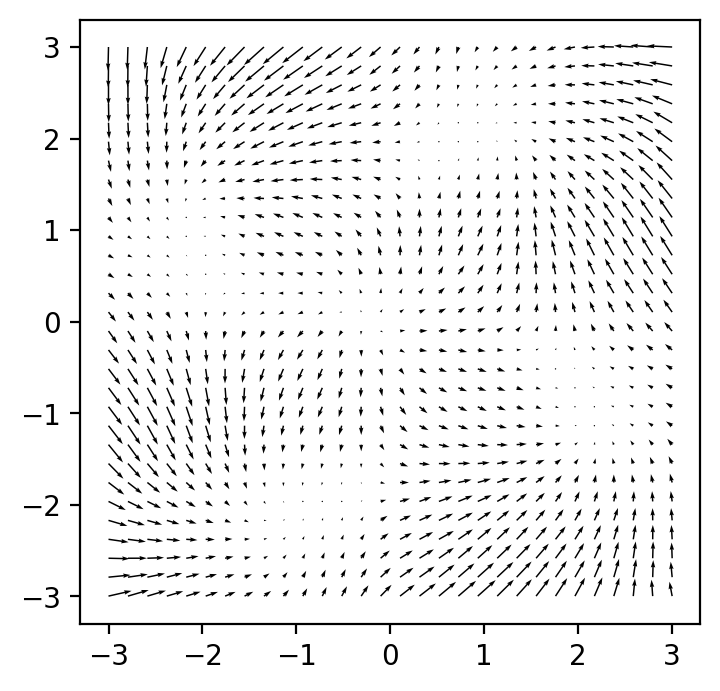

In [68]:
xs = torch.linspace(-3, 3, steps=30)
ys = torch.linspace(-3, 3, steps=30)
x, y = torch.meshgrid(xs, ys, indexing='xy')
z = model.force_model(torch.cat((x.unsqueeze(-1).cuda(), y.unsqueeze(-1).cuda()), dim=-1))
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111)
ax.quiver(x.numpy(), y.numpy(), DCN(z[..., 0]), DCN(z[..., 1]))

<IPython.core.display.Javascript object>


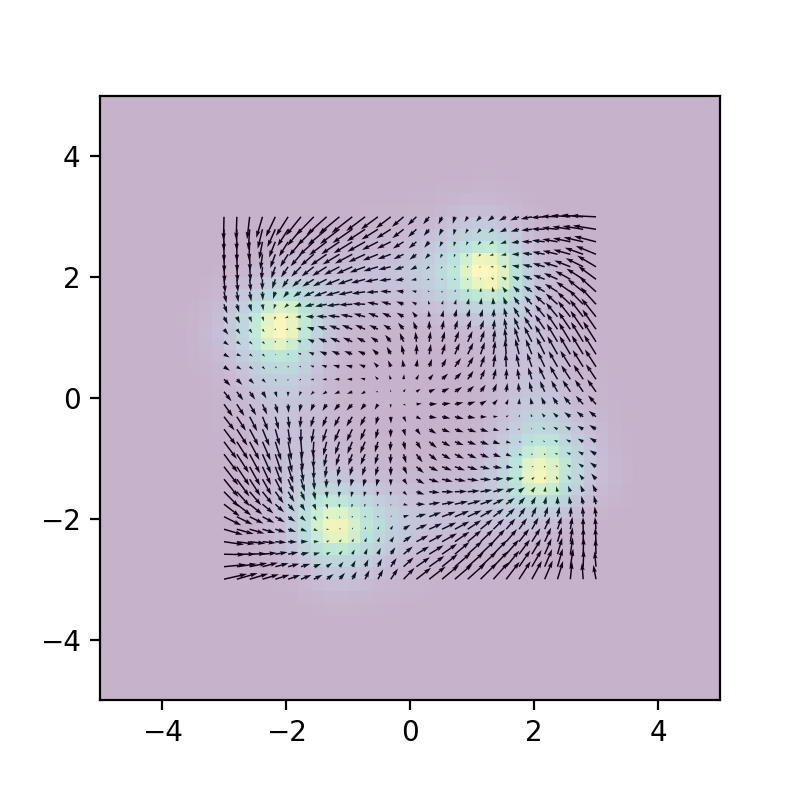

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
        -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
        -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
         1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
         3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
        -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
        -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
         1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
         3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 <matplotlib.collections.QuadMesh at 0x1c36f35ab08>)

In [82]:
xs = torch.linspace(-3, 3, steps=30)
ys = torch.linspace(-3, 3, steps=30)
x, y = torch.meshgrid(xs, ys, indexing='xy')
z = model.force_model(torch.cat((x.unsqueeze(-1).cuda(), y.unsqueeze(-1).cuda()), dim=-1))
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111)
ax.quiver(x.numpy(), y.numpy(), DCN(z[..., 0]), DCN(z[..., 1]))
ax.hist2d(train_data.reshape(-1, data_dim)[:, 0], train_data.reshape(-1, data_dim)[:, 1], bins=50, alpha=0.3, range=[[-5, 5],[-5, 5]]) 

In [88]:
torch.randn(30, 30, 10)[..., [1, 3, 5]].shape

torch.Size([30, 30, 3])

In [63]:
scale_tril = torch.zeros(model.d, model.d).cuda()
scale_tril[model.diag_ind[0], model.diag_ind[1]] = 1 + F.elu(model.diag_param)
scale_tril[model.off_diag_ind[0], model.off_diag_ind[1]] = model.off_diag_param
diff_matrix = torch.matmul(scale_tril, scale_tril.T)
print(diff_matrix)

tensor([[20.0657,  0.0653],
        [ 0.0653, 20.0654]], device='cuda:0', grad_fn=<MmBackward0>)


## ETC

In [ ]:
# Set random seed for reproducibility
SEED = 2589
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

    
class FieldLearning(nn.Module):
    def __init__(self, d, dt):
        super(FieldLearning, self).__init__()
        self.d = d  # space dimension
        self.dt = torch.tensor(dt)
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.force_model = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),

        )
        self.diff_model = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        force = force_model(x)
        diff_matrix = diff_model()
        dx = -force * self.dt + sqrtm(2 * diff_matrix) * torch.normal(mean=torch.zeros(self.d), std=torch.ones(self.d)) * torch.sqrt(self.dt)
        return dx